<a href="https://colab.research.google.com/github/swapniel99/erav1s8/blob/main/S8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!git clone https://github.com/swapniel99/erav1s8.git
%cd erav1s8/
!git pull
%ls

fatal: destination path 'erav1s8' already exists and is not an empty directory.
/content/erav1s8
Already up to date.
backprop.py  dataset.py  model.py      README.md         S8.ipynb
data/        erav1s8/    __pycache__/  requirements.txt  utils.py


In [3]:
from utils import *
set_seed(42)
device = get_device()

Device Selected: cuda


In [4]:
from dataset import CIFAR10
batch_size = 32
cifar10 = CIFAR10(batch_size)

Files already downloaded and verified
Files already downloaded and verified


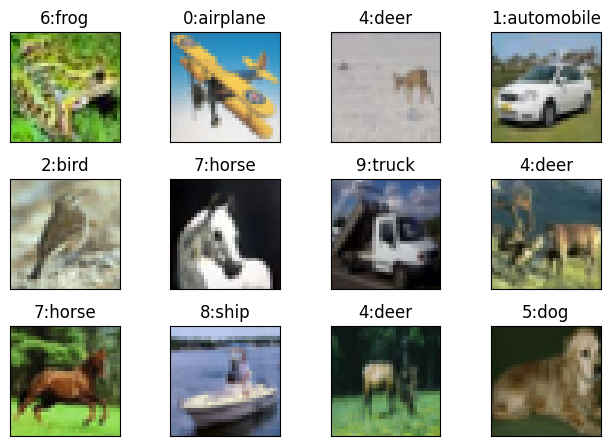

In [5]:
cifar10.show_examples()

In [6]:
from model import Model
from backprop import Experiment

# Experiment 1: Group Normalisation

In [7]:
model1 = Model(norm_type='group', n_groups=4)
model1.summary(input_size=(batch_size, 3, 32, 32))

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Param %
Model                                    [32, 3, 32, 32]           [32, 10]                  --                             --
├─Sequential: 1-1                        [32, 3, 32, 32]           [32, 16, 28, 28]          --                             --
│    └─Conv2d: 2-1                       [32, 3, 32, 32]           [32, 16, 30, 30]          432                         0.99%
│    └─GroupNorm: 2-2                    [32, 16, 30, 30]          [32, 16, 30, 30]          32                          0.07%
│    └─ReLU: 2-3                         [32, 16, 30, 30]          [32, 16, 30, 30]          --                             --
│    └─Conv2d: 2-4                       [32, 16, 30, 30]          [32, 16, 28, 28]          2,304                       5.30%
│    └─GroupNorm: 2-5                    [32, 16, 28, 28]          [32, 16, 28, 28]          32                

In [8]:
exp1 = Experiment(model1, cifar10)
exp1.execute()

Epoch 1


Train: Batch_id=1562, Average Loss=1.7947, Accuracy=32.47: 100%|██████████| 1563/1563 [00:29<00:00, 53.26it/s]


Test: Average loss: 1.4922, Accuracy: 44.32
Epoch 2


Train: Batch_id=1562, Average Loss=1.4140, Accuracy=48.39: 100%|██████████| 1563/1563 [00:28<00:00, 55.02it/s]


Test: Average loss: 1.4312, Accuracy: 48.59
Epoch 3


Train: Batch_id=1562, Average Loss=1.2355, Accuracy=55.50: 100%|██████████| 1563/1563 [00:28<00:00, 54.62it/s]


Test: Average loss: 1.1857, Accuracy: 57.19
Epoch 4


Train: Batch_id=1562, Average Loss=1.1250, Accuracy=59.51: 100%|██████████| 1563/1563 [00:28<00:00, 54.68it/s]


Test: Average loss: 1.2288, Accuracy: 56.21
Epoch 00004: reducing learning rate of group 0 to 5.0000e-03.
Epoch 5


Train: Batch_id=1562, Average Loss=0.9732, Accuracy=65.51: 100%|██████████| 1563/1563 [00:28<00:00, 54.70it/s]


Test: Average loss: 1.0301, Accuracy: 63.18
Epoch 6


Train: Batch_id=1562, Average Loss=0.9197, Accuracy=67.37: 100%|██████████| 1563/1563 [00:28<00:00, 54.86it/s]


Test: Average loss: 0.9443, Accuracy: 66.63
Epoch 7


Train: Batch_id=1562, Average Loss=0.8766, Accuracy=68.96: 100%|██████████| 1563/1563 [00:28<00:00, 54.97it/s]


Test: Average loss: 0.9128, Accuracy: 67.28
Epoch 8


Train: Batch_id=1562, Average Loss=0.8374, Accuracy=70.49: 100%|██████████| 1563/1563 [00:28<00:00, 54.55it/s]


Test: Average loss: 0.8753, Accuracy: 69.08
Epoch 9


Train: Batch_id=1562, Average Loss=0.8050, Accuracy=71.78: 100%|██████████| 1563/1563 [00:28<00:00, 54.57it/s]


Test: Average loss: 0.8815, Accuracy: 69.26
Epoch 00009: reducing learning rate of group 0 to 2.5000e-03.
Epoch 10


Train: Batch_id=1562, Average Loss=0.7186, Accuracy=74.91: 100%|██████████| 1563/1563 [00:28<00:00, 53.98it/s]


Test: Average loss: 0.7985, Accuracy: 71.90
Epoch 11


Train: Batch_id=1562, Average Loss=0.6998, Accuracy=75.57: 100%|██████████| 1563/1563 [00:29<00:00, 53.33it/s]


Test: Average loss: 0.8074, Accuracy: 71.90
Epoch 00011: reducing learning rate of group 0 to 1.2500e-03.
Epoch 12


Train: Batch_id=1562, Average Loss=0.6496, Accuracy=77.38: 100%|██████████| 1563/1563 [00:30<00:00, 51.52it/s]


Test: Average loss: 0.7904, Accuracy: 72.68
Epoch 13


Train: Batch_id=1562, Average Loss=0.6365, Accuracy=78.05: 100%|██████████| 1563/1563 [00:28<00:00, 55.24it/s]


Test: Average loss: 0.7714, Accuracy: 73.20
Epoch 14


Train: Batch_id=1562, Average Loss=0.6283, Accuracy=78.23: 100%|██████████| 1563/1563 [00:28<00:00, 53.99it/s]


Test: Average loss: 0.7697, Accuracy: 73.56
Epoch 15


Train: Batch_id=1562, Average Loss=0.6169, Accuracy=78.59: 100%|██████████| 1563/1563 [00:28<00:00, 54.54it/s]


Test: Average loss: 0.8062, Accuracy: 72.46
Epoch 00015: reducing learning rate of group 0 to 6.2500e-04.
Epoch 16


Train: Batch_id=1562, Average Loss=0.5868, Accuracy=79.77: 100%|██████████| 1563/1563 [00:28<00:00, 54.87it/s]


Test: Average loss: 0.7750, Accuracy: 73.27
Epoch 00016: reducing learning rate of group 0 to 3.1250e-04.
Epoch 17


Train: Batch_id=1562, Average Loss=0.5679, Accuracy=80.56: 100%|██████████| 1563/1563 [00:29<00:00, 53.79it/s]


Test: Average loss: 0.7611, Accuracy: 73.83
Epoch 18


Train: Batch_id=1562, Average Loss=0.5637, Accuracy=80.71: 100%|██████████| 1563/1563 [00:28<00:00, 54.75it/s]


Test: Average loss: 0.7556, Accuracy: 73.91
Epoch 19


Train: Batch_id=1562, Average Loss=0.5602, Accuracy=80.66: 100%|██████████| 1563/1563 [00:28<00:00, 54.76it/s]


Test: Average loss: 0.7579, Accuracy: 73.73
Epoch 00019: reducing learning rate of group 0 to 1.5625e-04.
Epoch 20


Train: Batch_id=1562, Average Loss=0.5508, Accuracy=81.13: 100%|██████████| 1563/1563 [00:28<00:00, 54.94it/s]


Test: Average loss: 0.7602, Accuracy: 73.76
Epoch 00020: reducing learning rate of group 0 to 7.8125e-05.


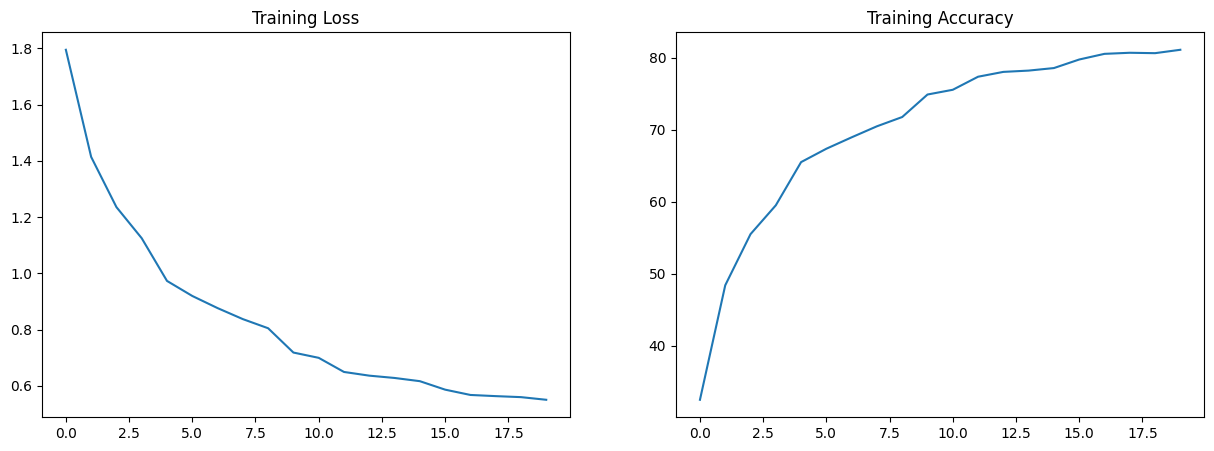

In [9]:
exp1.train.plot_stats()

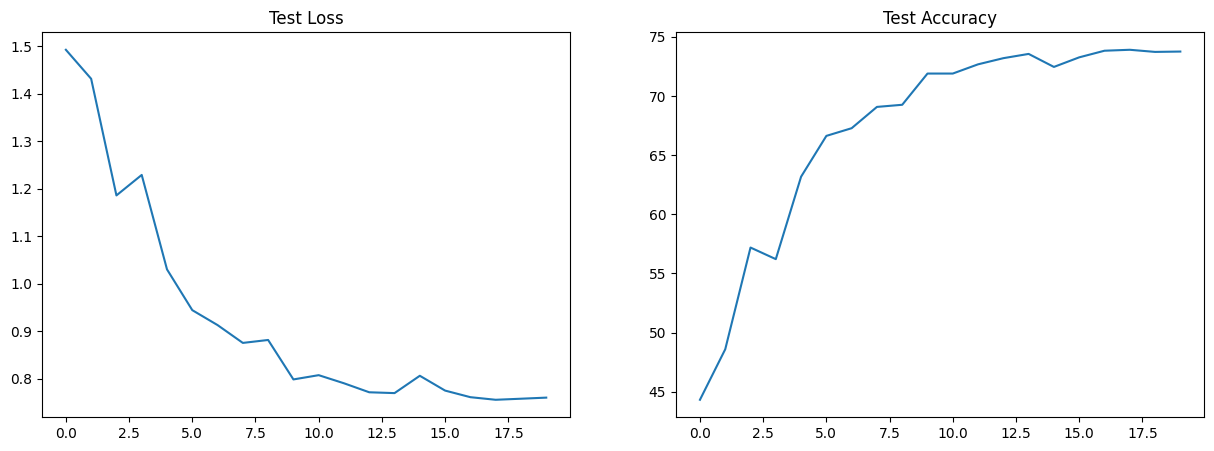

In [10]:
exp1.test.plot_stats()

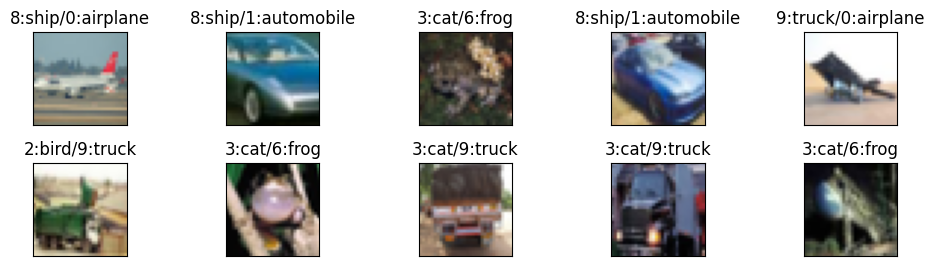

In [11]:
exp1.test.show_incorrect()

# Experiment 2: Layer Normalisation

In [12]:
model2 = Model(norm_type='layer')
model2.summary(input_size=(batch_size, 3, 32, 32))

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Param %
Model                                    [32, 3, 32, 32]           [32, 10]                  --                             --
├─Sequential: 1-1                        [32, 3, 32, 32]           [32, 16, 28, 28]          --                             --
│    └─Conv2d: 2-1                       [32, 3, 32, 32]           [32, 16, 30, 30]          432                         0.99%
│    └─GroupNorm: 2-2                    [32, 16, 30, 30]          [32, 16, 30, 30]          32                          0.07%
│    └─ReLU: 2-3                         [32, 16, 30, 30]          [32, 16, 30, 30]          --                             --
│    └─Conv2d: 2-4                       [32, 16, 30, 30]          [32, 16, 28, 28]          2,304                       5.30%
│    └─GroupNorm: 2-5                    [32, 16, 28, 28]          [32, 16, 28, 28]          32                

In [13]:
exp2 = Experiment(model2, cifar10)
exp2.execute()

Epoch 1


Train: Batch_id=1562, Average Loss=1.8385, Accuracy=31.35: 100%|██████████| 1563/1563 [00:28<00:00, 54.35it/s]


Test: Average loss: 1.6019, Accuracy: 41.31
Epoch 2


Train: Batch_id=1562, Average Loss=1.5244, Accuracy=43.69: 100%|██████████| 1563/1563 [00:28<00:00, 55.55it/s]


Test: Average loss: 1.3770, Accuracy: 49.37
Epoch 3


Train: Batch_id=1562, Average Loss=1.3548, Accuracy=50.47: 100%|██████████| 1563/1563 [00:28<00:00, 54.97it/s]


Test: Average loss: 1.3338, Accuracy: 51.05
Epoch 4


Train: Batch_id=1562, Average Loss=1.2207, Accuracy=55.73: 100%|██████████| 1563/1563 [00:28<00:00, 55.07it/s]


Test: Average loss: 1.1549, Accuracy: 57.53
Epoch 5


Train: Batch_id=1562, Average Loss=1.1276, Accuracy=59.34: 100%|██████████| 1563/1563 [00:28<00:00, 54.08it/s]


Test: Average loss: 1.1889, Accuracy: 56.54
Epoch 00005: reducing learning rate of group 0 to 5.0000e-03.
Epoch 6


Train: Batch_id=1562, Average Loss=0.9885, Accuracy=64.73: 100%|██████████| 1563/1563 [00:28<00:00, 54.48it/s]


Test: Average loss: 0.9965, Accuracy: 64.13
Epoch 7


Train: Batch_id=1562, Average Loss=0.9459, Accuracy=66.23: 100%|██████████| 1563/1563 [00:28<00:00, 54.92it/s]


Test: Average loss: 0.9643, Accuracy: 65.78
Epoch 8


Train: Batch_id=1562, Average Loss=0.9117, Accuracy=67.60: 100%|██████████| 1563/1563 [00:28<00:00, 55.51it/s]


Test: Average loss: 0.9183, Accuracy: 67.17
Epoch 9


Train: Batch_id=1562, Average Loss=0.8825, Accuracy=68.60: 100%|██████████| 1563/1563 [00:28<00:00, 54.61it/s]


Test: Average loss: 0.8909, Accuracy: 68.56
Epoch 10


Train: Batch_id=1562, Average Loss=0.8565, Accuracy=69.62: 100%|██████████| 1563/1563 [00:28<00:00, 54.11it/s]


Test: Average loss: 0.9058, Accuracy: 68.23
Epoch 00010: reducing learning rate of group 0 to 2.5000e-03.
Epoch 11


Train: Batch_id=1562, Average Loss=0.7717, Accuracy=72.60: 100%|██████████| 1563/1563 [00:28<00:00, 55.19it/s]


Test: Average loss: 0.8391, Accuracy: 70.32
Epoch 12


Train: Batch_id=1562, Average Loss=0.7520, Accuracy=73.57: 100%|██████████| 1563/1563 [00:28<00:00, 54.87it/s]


Test: Average loss: 0.8533, Accuracy: 70.11
Epoch 00012: reducing learning rate of group 0 to 1.2500e-03.
Epoch 13


Train: Batch_id=1562, Average Loss=0.7044, Accuracy=75.16: 100%|██████████| 1563/1563 [00:28<00:00, 55.36it/s]


Test: Average loss: 0.8226, Accuracy: 71.02
Epoch 14


Train: Batch_id=1562, Average Loss=0.6905, Accuracy=75.73: 100%|██████████| 1563/1563 [00:28<00:00, 55.35it/s]


Test: Average loss: 0.8297, Accuracy: 70.59
Epoch 00014: reducing learning rate of group 0 to 6.2500e-04.
Epoch 15


Train: Batch_id=1562, Average Loss=0.6645, Accuracy=76.75: 100%|██████████| 1563/1563 [00:28<00:00, 55.20it/s]


Test: Average loss: 0.8044, Accuracy: 71.84
Epoch 16


Train: Batch_id=1562, Average Loss=0.6567, Accuracy=77.00: 100%|██████████| 1563/1563 [00:28<00:00, 55.49it/s]


Test: Average loss: 0.8047, Accuracy: 71.92
Epoch 00016: reducing learning rate of group 0 to 3.1250e-04.
Epoch 17


Train: Batch_id=1562, Average Loss=0.6411, Accuracy=77.63: 100%|██████████| 1563/1563 [00:28<00:00, 55.59it/s]


Test: Average loss: 0.7914, Accuracy: 71.84
Epoch 18


Train: Batch_id=1562, Average Loss=0.6375, Accuracy=77.73: 100%|██████████| 1563/1563 [00:28<00:00, 54.76it/s]


Test: Average loss: 0.7933, Accuracy: 71.96
Epoch 00018: reducing learning rate of group 0 to 1.5625e-04.
Epoch 19


Train: Batch_id=1562, Average Loss=0.6285, Accuracy=78.15: 100%|██████████| 1563/1563 [00:28<00:00, 55.46it/s]


Test: Average loss: 0.7890, Accuracy: 71.87
Epoch 20


Train: Batch_id=1562, Average Loss=0.6267, Accuracy=78.14: 100%|██████████| 1563/1563 [00:29<00:00, 53.15it/s]


Test: Average loss: 0.7900, Accuracy: 72.15
Epoch 00020: reducing learning rate of group 0 to 7.8125e-05.


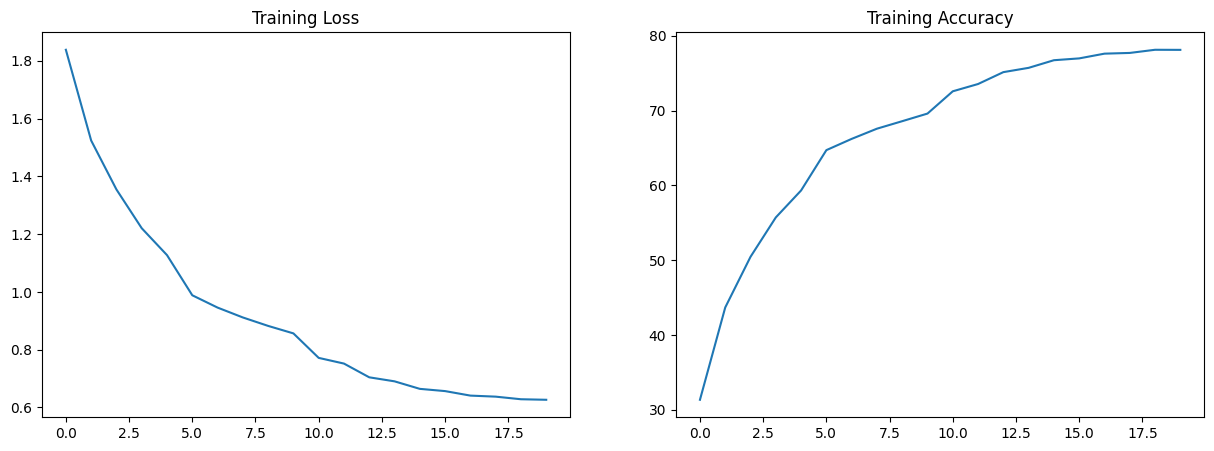

In [14]:
exp2.train.plot_stats()

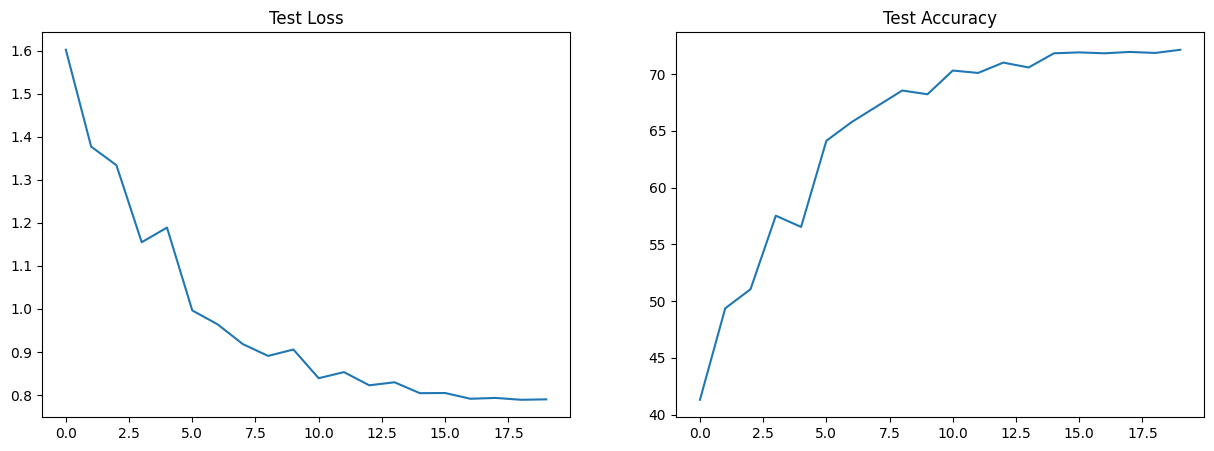

In [15]:
exp2.test.plot_stats()

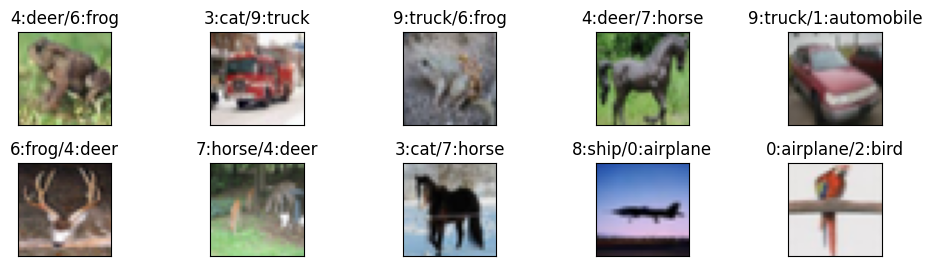

In [16]:
exp2.test.show_incorrect()

# Experiment 3: Batch Normalisation

In [17]:
model3 = Model(norm_type='batch')
model3.summary(input_size=(batch_size, 3, 32, 32))

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Param %
Model                                    [32, 3, 32, 32]           [32, 10]                  --                             --
├─Sequential: 1-1                        [32, 3, 32, 32]           [32, 16, 28, 28]          --                             --
│    └─Conv2d: 2-1                       [32, 3, 32, 32]           [32, 16, 30, 30]          432                         0.99%
│    └─BatchNorm2d: 2-2                  [32, 16, 30, 30]          [32, 16, 30, 30]          32                          0.07%
│    └─ReLU: 2-3                         [32, 16, 30, 30]          [32, 16, 30, 30]          --                             --
│    └─Conv2d: 2-4                       [32, 16, 30, 30]          [32, 16, 28, 28]          2,304                       5.30%
│    └─BatchNorm2d: 2-5                  [32, 16, 28, 28]          [32, 16, 28, 28]          32                

In [18]:
exp3 = Experiment(model3, cifar10)
exp3.execute()

Epoch 1


Train: Batch_id=1562, Average Loss=1.4521, Accuracy=46.49: 100%|██████████| 1563/1563 [00:27<00:00, 55.92it/s]


Test: Average loss: 1.2166, Accuracy: 56.48
Epoch 2


Train: Batch_id=1562, Average Loss=1.0912, Accuracy=60.97: 100%|██████████| 1563/1563 [00:27<00:00, 55.90it/s]


Test: Average loss: 1.0411, Accuracy: 62.43
Epoch 3


Train: Batch_id=1562, Average Loss=0.9452, Accuracy=66.46: 100%|██████████| 1563/1563 [00:27<00:00, 56.71it/s]


Test: Average loss: 0.9355, Accuracy: 67.94
Epoch 4


Train: Batch_id=1562, Average Loss=0.8600, Accuracy=69.63: 100%|██████████| 1563/1563 [00:28<00:00, 55.52it/s]


Test: Average loss: 0.8533, Accuracy: 69.93
Epoch 5


Train: Batch_id=1562, Average Loss=0.7913, Accuracy=72.09: 100%|██████████| 1563/1563 [00:27<00:00, 56.24it/s]


Test: Average loss: 0.8120, Accuracy: 71.78
Epoch 6


Train: Batch_id=1562, Average Loss=0.7420, Accuracy=73.92: 100%|██████████| 1563/1563 [00:27<00:00, 55.98it/s]


Test: Average loss: 0.7590, Accuracy: 73.91
Epoch 7


Train: Batch_id=1562, Average Loss=0.7031, Accuracy=75.70: 100%|██████████| 1563/1563 [00:28<00:00, 55.35it/s]


Test: Average loss: 0.7453, Accuracy: 74.45
Epoch 8


Train: Batch_id=1562, Average Loss=0.6716, Accuracy=76.79: 100%|██████████| 1563/1563 [00:28<00:00, 55.63it/s]


Test: Average loss: 0.7216, Accuracy: 74.93
Epoch 9


Train: Batch_id=1562, Average Loss=0.6457, Accuracy=77.43: 100%|██████████| 1563/1563 [00:27<00:00, 56.22it/s]


Test: Average loss: 0.6953, Accuracy: 76.22
Epoch 10


Train: Batch_id=1562, Average Loss=0.6226, Accuracy=77.99: 100%|██████████| 1563/1563 [00:27<00:00, 57.69it/s]


Test: Average loss: 0.6908, Accuracy: 76.21
Epoch 11


Train: Batch_id=1562, Average Loss=0.5996, Accuracy=79.08: 100%|██████████| 1563/1563 [00:27<00:00, 56.13it/s]


Test: Average loss: 0.6870, Accuracy: 76.32
Epoch 12


Train: Batch_id=1562, Average Loss=0.5784, Accuracy=79.85: 100%|██████████| 1563/1563 [00:29<00:00, 53.27it/s]


Test: Average loss: 0.6864, Accuracy: 77.07
Epoch 13


Train: Batch_id=1562, Average Loss=0.5624, Accuracy=80.27: 100%|██████████| 1563/1563 [00:28<00:00, 54.79it/s]


Test: Average loss: 0.7031, Accuracy: 76.61
Epoch 00013: reducing learning rate of group 0 to 5.0000e-03.
Epoch 14


Train: Batch_id=1562, Average Loss=0.4906, Accuracy=82.99: 100%|██████████| 1563/1563 [00:28<00:00, 55.74it/s]


Test: Average loss: 0.6354, Accuracy: 78.78
Epoch 15


Train: Batch_id=1562, Average Loss=0.4715, Accuracy=83.46: 100%|██████████| 1563/1563 [00:27<00:00, 55.86it/s]


Test: Average loss: 0.6472, Accuracy: 78.35
Epoch 00015: reducing learning rate of group 0 to 2.5000e-03.
Epoch 16


Train: Batch_id=1562, Average Loss=0.4248, Accuracy=85.41: 100%|██████████| 1563/1563 [00:28<00:00, 54.64it/s]


Test: Average loss: 0.6174, Accuracy: 79.07
Epoch 17


Train: Batch_id=1562, Average Loss=0.4156, Accuracy=85.33: 100%|██████████| 1563/1563 [00:28<00:00, 55.81it/s]


Test: Average loss: 0.6183, Accuracy: 79.24
Epoch 00017: reducing learning rate of group 0 to 1.2500e-03.
Epoch 18


Train: Batch_id=1562, Average Loss=0.3898, Accuracy=86.45: 100%|██████████| 1563/1563 [00:28<00:00, 55.35it/s]


Test: Average loss: 0.6269, Accuracy: 79.25
Epoch 00018: reducing learning rate of group 0 to 6.2500e-04.
Epoch 19


Train: Batch_id=1562, Average Loss=0.3762, Accuracy=87.11: 100%|██████████| 1563/1563 [00:28<00:00, 54.49it/s]


Test: Average loss: 0.6142, Accuracy: 79.68
Epoch 20


Train: Batch_id=1562, Average Loss=0.3731, Accuracy=87.22: 100%|██████████| 1563/1563 [00:28<00:00, 55.65it/s]


Test: Average loss: 0.6176, Accuracy: 79.36
Epoch 00020: reducing learning rate of group 0 to 3.1250e-04.


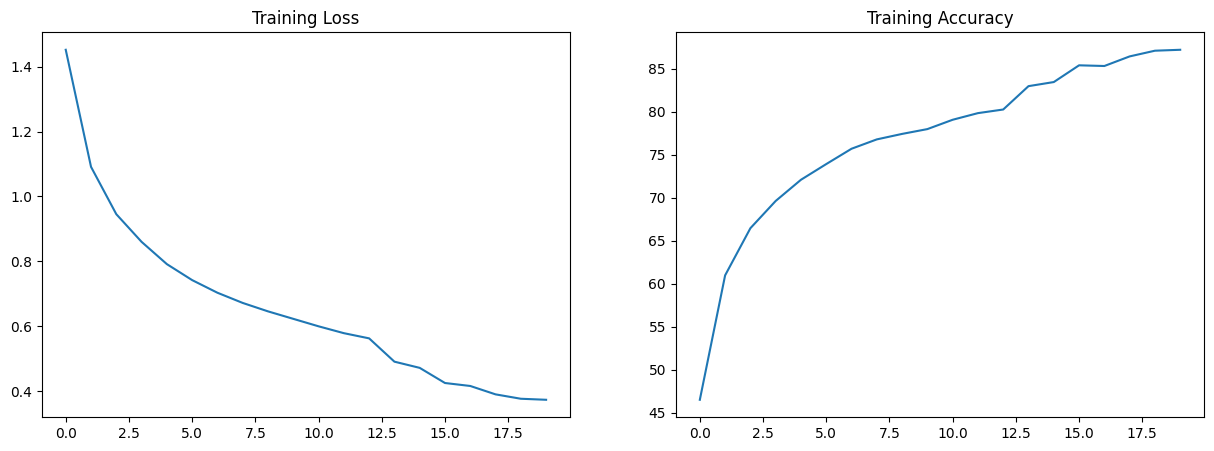

In [19]:
exp3.train.plot_stats()

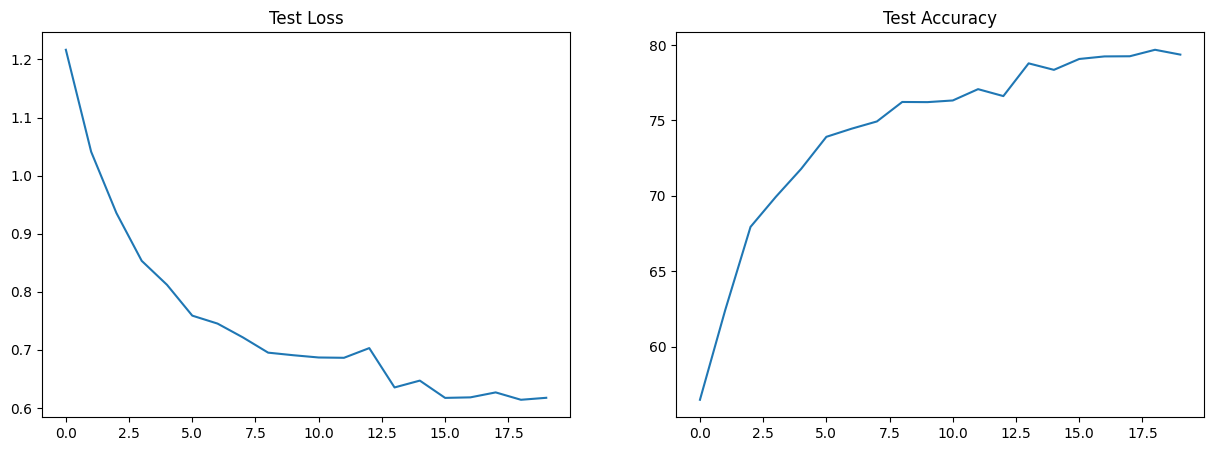

In [20]:
exp3.test.plot_stats()

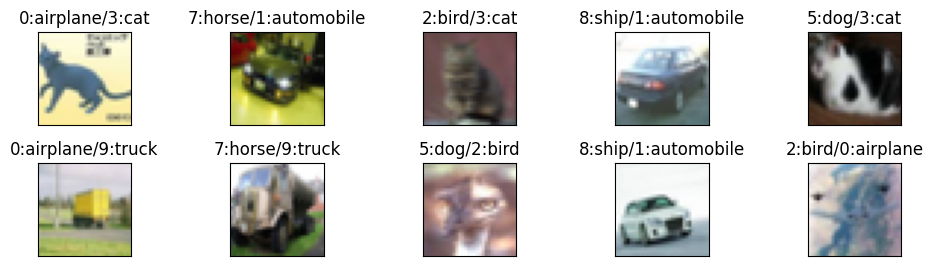

In [21]:
exp3.test.show_incorrect()